---
title: "Downstream Risk Implications of Derivative Pricing Models: An End-to-End Market Risk Modelling Study"
format:
  pdf:
    toc: true
    toc-depth: 3
    geometry:
      - margin=15mm
---

## Section 1: Introduction and Summary

**1.1. Project Overview and Objective**

Market risk modelling for equity derivatives relies fundamentally on the interaction between upstream pricing models and downstream risk analytics, where valuation engines serve as inputs into P&L simulation, exposure profiling, and regulatory risk measurement. While derivative pricing models are often evaluated on valuation accuracy in isolation, their distributional assumptions and dynamic structures play a critical role in shaping downstream risk estimates used for trading book risk management and capital assessment.

The objective of this study is to systematically examine the downstream risk implications of three widely used equity derivative pricing frameworks—Monte-Carlo simulation, Black-Scholes-Merton (BSM), and the Heston stochastic volatility model—by benchmarking how their respective modelling assumptions propagate into market risk measures and factor-based risk diagnostics. The analysis is conducted within an end-to-end market risk modelling pipeline, spanning price generation, P&L simulation, and tail-risk evaluation. Two parallel datasets are employed: a proxy-based dataset designed to support methodological transparency and regulatory defensibility, and an ETF-based dataset used for external price anchoring and empirical realism.

Rather than proposing a novel pricing methodology, this research adopts a risk-centric perspective, focusing on comparative robustness, distributional fidelity, and stability of downstream risk metrics under realistic data, calibration, and governance constraints. The study is explicitly framed to reflect the considerations faced by market risk, model validation, and regulatory risk teams, where the primary concern is not pricing optimality in isolation, but the coherence, interpretability, and reliability of risk estimates derived from model-implied price dynamics.


**1.2. Overview of the Models Considered**

The three models examined in this study span a spectrum of theoretical assumptions and practical complexity:

- Black-Scholes-Merton (BSM) represents the classical closed-form solution for European option pricing, assuming log-normally distributed asset prices, constant volatility, frictionless markets, and continuous hedging. Despite well-documented empirical violations of these assumptions, BSM remains an industry benchmark due to its interpretability, analytical tractability, and historical adoption.

- The Heston stochastic volatility model extends the BSM framework by introducing a mean-reverting stochastic process for volatility, thereby capturing volatility clustering and leverage effects observed in real markets. While more flexible than BSM, the Heston model introduces calibration complexity, numerical stability considerations, and additional parameter uncertainty.

- Monte-Carlo simulation, implemented in this study using a bootstrap-based, non-parametric approach, avoids strong parametric assumptions about return distributions. Instead, it relies on empirically observed return dynamics to generate future price paths, allowing for skewness, excess kurtosis, and regime-specific behavior to be preserved in simulated outcomes.

Together, these models enable a structured comparison between analytical tractability, stochastic realism, and empirically driven distributional modeling. Given the dual data architecture adopted in this study—European-style proxy options for model development and American-style ETF options for external benchmarking—the **Longstaff–Schwartz (LSMC) methodology for approximating optimal early-exercise decisions in American options** is employed solely as a conditional early-exercise valuation operator where required. Importantly, LSMC is not treated as an independent pricing model, nor is it used in downstream risk generation; its role is limited to ensuring comparability and pricing realism when benchmarking against observed ETF option markets.


**1.3. Data Architecture and Dual-ETL Design**

A key design feature of this project is the construction of two distinct ETL pipelines, motivated by data availability constraints and regulatory considerations.

- The proxy-based dataset is constructed using liquid, publicly available equity and index data to create synthetic underlying assets suitable for model development, stress testing, and out-of-sample evaluation. This pipeline emphasizes transparency, reproducibility, long historical coverage, and suitability for statistical testing and regulatory defense. The proxy dataset serves as the primary foundation for model calibration, simulation, and risk evaluation. For the proxy dataset architecture, European options have been leveraged.

- The ETF-based dataset sources option-relevant price information derived from exchange-traded funds tracking the same or closely related underlying assets. This pipeline is used exclusively for external price comparison, visual benchmarking, and plausibility checks of model-implied option prices. Due to limitations associated with free and publicly accessible option datasets for European options, the ETF architecture leverages American options.

While European and American options will share stochasticity, American options come with the added complexity of exercise time. I.e., while European options exercise only at maturity, American options can be exercised at any point in time (as long as exercise date <= maturity date of the contract). Hence, the proxy-based architecture is used to assess the realism and stability of alternative stochastic volatility specifications under controlled European-style contracts. These findings inform — but do not determine — the interpretation of results in the ETF-based American option framework, where all candidate dynamics are evaluated under a common early-exercise valuation methodology against observed market prices.

Essentially, while $European Options = Stochastic Modelling$, $American Options = Stochastic Modelling + Exercise Time Handling$. For approximating optimal early-exercise decisions, the LSMC methodology has been considered.


**1.4. Statistical Diagnostics and Distributional Testing**

Prior to model implementation, extensive statistical diagnostics are applied to the proxy-based dataset to assess the validity of common modeling assumptions. These diagnostics include:

- Tests for normality and log-normality of returns
- Evaluation of skewness and excess kurtosis
- Analysis of volatility clustering and regime dependence

Empirical evidence of non-Gaussian return behavior, fat tails, and asymmetry motivates the inclusion of a bootstrap-based Monte-Carlo framework and informs the interpretation of results obtained from parametric models such as BSM and Heston.


**1.5. Out-of-Sample Evaluation Framework**

Model evaluation is conducted using a clearly defined out-of-sample (OOS) framework, designed to assess robustness rather than in-sample fit. OOS parameters are selected to capture multiple dimensions of model performance, including:

- Pricing stability across market regimes
- Tail risk behavior and downside sensitivity
- Risk decomposition and factor exposure consistency

The evaluation framework emphasizes comparative behavior under identical inputs, ensuring that differences in outcomes can be attributed to model structure rather than data artifacts.


**1.6. Implementation Methodology (Summary)**

The overall implementation methodology follows a structured and reproducible sequence:

 1. Construction of proxy-based and ETF-based ETL pipelines 
 2. Statistical diagnostics and assumption testing on proxy data 
 3. Independent implementation of Monte-Carlo, BSM, and Heston models 
 4. Model calibration and numerical validation, where applicable
 5. ETF-based benchmarking for external pricing plausibility and realism 
 6. Proxy-based out-of-sample risk and stability evaluation (including Barra-style risk identification and other OOS risk metrics like CVaR, VaR, TLF, ESD, etc.) 
 7. Comparative analysis and final research findings across all models and evaluation metrics

While steps 1 to 4 and 6 will leverage proxy data, step 5 will leverage the ETF data for external price plausibility and realism. Additionally, all downstream risk and stability analyses are conducted using the proxy-based architecture.

**1.7. Summary of Findings**

**TO BE FILLED IN THE END**


**1.8. Compliance with SR 11-7 Model Risk and Governance Framework**

**TO BE FILLED IN THE END**


**Disclaimer**

This document is intended solely for academic, educational, and research purposes. The models, methodologies, data sources, and results presented herein are illustrative in nature and are not intended to constitute investment advice, trading recommendations, or financial forecasts. Any references to market instruments, prices, or returns are for analytical demonstration only. The analyses rely on publicly available data and simplifying assumptions, and may not fully capture real-world market frictions, liquidity constraints, transaction costs, or institutional trading considerations. This document does not intend to provide representations regarding the suitability of any model or result for live trading, risk management, or regulatory capital determination.

In [1]:
# Import necessary packages
import os, time, requests, json
from dotenv import load_dotenv
from contextlib import contextmanager
from IPython.display import display
from scipy.stats import kurtosis, skew, jarque_bera, anderson
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd, numpy as np, matplotlib.pyplot as plt, yfinance as yf, seaborn as sns, statsmodels.api as sm, scipy.stats as stats

# Initializing environment
load_dotenv()
zero_coupon_ecb = os.getenv('zero_coupon_ecb')
zero_coupon_fred = os.getenv('zero_coupon_fred')
proxy_master = os.getenv('proxy_master')
etf_master = os.getenv('etf_master')
fred_api_key = os.getenv('fred_api_key')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Defining time context block
@contextmanager
def time_block(label: str='Block'):
    start_time = time.perf_counter()
    try:
        yield
    finally:
        end_time = time.perf_counter()
        runtime = end_time - start_time
        print(f'{label} execution time: {runtime/60:.2f} minutes.')


## Section 2: Implementation of ETL Pipelines

**2.1. Overview**

This project adopts a dual data-architecture strategy to balance **economic correctness**, **empirical validation**, and **data accessibility constraints**:

- **Proxy-based architecture**:
  This architecture constructs a synthetic yet economically grounded state-space of contingent claims, designed to support model development, assumption testing, and controlled out-of-sample (OOS) evaluation. The approach deliberately decouples contract specification from market-quoted option chains by defining options across fixed grids of moneyness, maturity, and payoff type, while anchoring all valuations to observed underlying prices, realized volatility proxies, risk-free term structures, and dividend yield assumptions. By holding the contract space and input state variables constant, the framework enables clean comparative benchmarking of pricing models, ensuring that observed differences in valuation and risk metrics are attributable to model dynamics rather than data availability, liquidity effects, or market microstructure noise. This proxy-based design emphasizes transparency, economic interpretability, numerical stability, and robustness under model governance and regulatory scrutiny, consistent with principles outlined in formal model-risk management frameworks.

- **ETF-based architecture**: 
  This architecture leverages exchange-traded fund (ETF) option chains as market-anchored representations of contingent claims, designed to support empirical validation, calibration realism, and external consistency checks against observed option prices. The approach preserves the contract specifications embedded in traded ETF options, including listed strikes, standardized maturities, and observed call/put structures, while anchoring valuations to market-implied prices, bid–ask dynamics, and prevailing liquidity conditions. As a result, the ETF-based framework reflects the joint influence of investor demand, hedging activity, volatility risk premia, and market microstructure effects inherent in real-world options markets. By operating directly on quoted option chains, the architecture enables assessment of absolute pricing accuracy, calibration stability, and model fit to observed market prices, complementing the controlled benchmarking enabled by the proxy-based framework. Differences between model-implied and market-observed prices can therefore be interpreted in the context of model assumptions, volatility dynamics, and unmodeled risk premia, rather than purely synthetic contract design. This ETF-based design emphasizes market realism, empirical validity, and external benchmark alignment, providing a necessary counterbalance to synthetic architectures and supporting robust model validation, sensitivity analysis, and governance-oriented performance assessment when used in conjunction with controlled proxy-based evaluations.

- **Why a dual-architecture setup**:
  The dual-architecture design addresses the absence of licensed market data feeds (e.g., Bloomberg, Refinitiv, Eurex) while maintaining methodological rigor consistent with institutional model development practices. Early stages of model development—including assumption testing, sensitivity analysis, and numerical stability checks—require controlled experimentation, isolation of effects, and a repeatable state-space. These requirements are satisfied by the proxy-based architecture, but cannot be reliably met using a purely ETF-based framework due to changing contract availability, liquidity effects, and embedded market risk premia. In contrast, later stages of model calibration and out-of-sample (OOS) validation benefit from direct exposure to market-quoted option prices, where an ETF-based architecture provides a realistic representation of observed pricing dynamics that a proxy-based framework cannot replicate. This separation is consistent with formal model-risk management guidance. In particular, SR 11-7 states that *“model validation should employ a combination of theoretical evaluation, controlled testing, and benchmarking against observed outcomes.”* The dual-architecture setup operationalizes this principle by explicitly separating controlled model diagnostics from market-anchored validation, ensuring both interpretability and empirical relevance.

>**Notes**: 
>While European and American options will share stochasticity, American options come with the added complexity of exercise time. I.e., while European options exercise ONLY at maturity, American options can be exercised at any point in time (as long as exercise date <= maturity date of the contract). Hence, the proxy-based architecture is used to assess the realism and stability of alternative stochastic volatility specifications under controlled European-style contracts. These findings inform—but do not determine—model preference in the ETF-based American option framework, where all candidate dynamics are evaluated under a common early-exercise methodology against observed market prices. Hence, for Proxy architecture "EXSA.DE (iShares STOXX Europe 600 UCITS ETF (DE) EUR (Dist))" closing prices have been considered and for ETF architecture "SPY (State Street SPDR S&P 500 ETF Trust)" closing prices and option chain have been considered - with dividend yield held as constant.
>Fundamentally, the proxy architecture answers the question **"Given a clean, European, long-history equity proxy, how do different stochastic dynamics compare relative to each other in terms of realism, stability, and numerical behavior?"** where as the ETF architecture answers the question **"Given observable option markets on a different but comparable equity benchmark, do those relative model characteristics persist when confronted with real prices?"**.


**2.2. ETL Pipeline**

In alignment with the SR 11-7 Model Risk Management framework, the project implements the following standardized ETL pipeline for both data architectures:

- **Step 1: Data Acquisition:** Sourcing raw market observables from documented, reproducible open-source channels.

- **Step 2: Data Ingestion:** Structured loading into analysis-ready data containers with version control and timestamping.

- **Step 3: Data Cleansing:** Handling missing values, calendar alignment, corporate action adjustments, and data sanity checks.

- **Step 4: Feature Engineering (as required):** Construction of derived quantities such as log returns, realized volatility measures, and term-structure interpolations.

- **Step 5: Rendering Model-Ready Datasets:** Final transformation into inputs compatible with Black–Scholes–Merton, Heston, and Monte Carlo pricing frameworks.

This pipeline separation ensures traceability, auditability, and reproducibility—key SR 11-7 requirements.


**2.3. Data Acquisition Sources and Rationale — Proxy-Based Architecture**

Under the proxy-based architecture, the following data components are sourced to construct a **theoretically consistent index-level pricing environment**. These inputs are used for model calibration, assumption testing, and controlled comparative analysis rather than direct replication of observed option prices.

Main Area 1: Underlying Index Prices - *Used to compute log returns, realized volatility, and to define the underlying state variable.*

- Daily closing prices - *Source: Yahoo Finance – EXSA.DE*  
- Trading calendar and date alignment - *Derived from ETF price time series*

Main Area 2: Realized Volatility Proxy - *Used to characterize historical volatility dynamics and provide data-driven inputs and initial conditions for stochastic volatility models.*

- Rolling realized volatility (21 days) - *Engineered from log returns derived in Main Area 1*  
- Rolling realized volatility (63 days) - *Engineered from log returns derived in Main Area 1*
- EWMA realized volatility - *Computed from historical log returns using exponentially decaying weights*

> **Note:** Full implied volatility surfaces are not available via open-source channels for European indices. Volatility indices are therefore engineered for this project using realized returns data.

Main Area 3: Risk-Free Rate Term Structure - *Used for discounting option payoffs and defining the risk-neutral drift.*

- Zero-coupon yields by maturity - *Source: European Central Bank – Data Portal*

> **Note:** Annualized continuously compounded zero-coupon yields - published on an ACT/365 basis - across multiple maturities observed daily. Retrieval mode: JSON dumps from public URLs published by ECB. 

Main Area 4: Dividend Yield - *Used to correct forward price dynamics and maintain put–call parity consistency.*

- Index-level dividend yield (spot or trailing) - *Source: Yahoo Finance - EXSA.DE – index `dividendYield` field*

> **Note:** The dividend yield is treated as constant over time, consistent with standard equity option pricing practice.

Main Area 5: Option Chain Construction and Pricing - *Used for inter-model benchmarking, internal consistency checks, and analysis of model-implied smile and skew behavior.*

- Option type (Call / Put) - *Constructed using simple classification*
- Strike price grid (K) - *Constructed using volatility-scaled spot log-moneyness. $K = S_t * e^k$ where $k = L * \sigma_a * \sqrt(T)$*
- Time to maturity (T) - *Constructed - as per zero-coupon maturity dates*

>**Note:**
>To preserve economic relevance and numerical stability, the log-moneyness domain is capped between -0.7 and 0.7 while allowing volatility regimes to retain regime shocks and affect pricing within the admissible contract space. Without capping our k-values amplify mathematically (not economically) since $k \propto \sigma * \sqrt{T} * L$ hence, during high time to maturity and volatility grids (e.g., 2008 + 10Y) the k-values get mathematically amplified - which lead to Far OTM and Deep ITM strike prices - rendering price ~0, greek ~0 and all 3 models being numerically indistinguishable from one another. Hence, to avoid this mathematical noise, capping has been enforced.

> **Important Clarification:**  
> Under the proxy-based architecture, **no observed market option prices are sourced**. Option prices are fully **model-implied**, enabling controlled comparison of pricing dynamics across Black–Scholes–Merton, Heston, and Monte Carlo frameworks without contamination from microstructure noise or liquidity effects. Additionally, under the proxy architecture, for each observed market state, we fix the underlying economic variables and enumerate a controlled grid of contingent claims. Pricing models are then applied to this fixed state-space, allowing downstream P&L, Greeks, and tail-risk measures to be compared on a like-for-like basis without contamination from liquidity or market microstructure effects.


**2.4. Data Acquisition Sources and Rationale — ETF-Based Architecture**

The ETF-based architecture is introduced to provide **empirical pricing benchmarks** using observable option markets on highly liquid exchange-traded funds. While ETFs introduce tracking error and structural noise, their option chains offer the only feasible open-source alternative for observed option prices. Additionally, under the ETF-based architecture, the ETF itself is treated as the underlying tradable asset; index replication is not assumed.

The data points mirror those used in the proxy-based architecture to ensure methodological consistency; however, **data sources differ materially**.

Main Area 1: Underlying ETF Prices - *Used as the tradable underlying for observed option contracts.*

- Daily closing and adjusted prices - *Source: Yahoo Finance – SPY*  
- Trading calendar - *Derived from ETF price series*

Main Area 2: Implied Volatility (Observed) - *Computed via model inversion from observable option mid-market prices for liquid ETFs and used for empirical benchmarking and validation.*

- Option-implied volatility (by strike and maturity) - *Extracted from Yahoo Finance (SPY) ETF option chains and cleaned for liquidity and data quality*

Main Area 3: Risk-Free Rate Term Structure - *Used for discounting option payoffs and defining the risk-neutral drift.*

- Zero-coupon yields by maturity - *Source: FRED  - API*

Main Area 4: Dividend Yield - *Used to correct forward price dynamics and maintain put–call parity consistency.*

- ETF dividend yield - *Source: Yahoo Finance – SPY - index `dividendYield` field*

Main Area 5: Observed Option Chain Data - *Used for direct model-to-market pricing comparison and OOS evaluation.*

- Option type (Call / Put) - *Source: Yahoo Finance SPY option chains*
- Strike price (K) - *Source: Yahoo Finance SPY option chains*
- Expiration date and time to maturity (T) - *Source: Yahoo Finance SPY option chains*
- Market option prices (mid, bid–ask) - *Source: Yahoo Finance SPY option chains*
- Volume and open interest (where available) - *Source: Yahoo Finance SPY option chains*

>**Important Clarification:**
>Due to the unavailability of reliable open-source historical option chain data for ETFs, the ETF-based architecture is implemented as a point-in-time benchmark. Its purpose is not time-series evaluation, but to assess whether the relative pricing behavior and structural characteristics observed under the proxy architecture remain economically plausible when confronted with observable market prices.

**Governance Note (SR 11-7 Alignment)**

The separation of proxy-based and ETF-based architectures ensures:

- Explicit documentation of data limitations and assumptions
- Clear distinction between **model development** and **empirical validation**
- Avoidance of overfitting or misrepresentation of model accuracy
- Traceability of all inputs to reproducible sources

This design aligns with SR 11-7 expectations regarding model transparency, validation independence, and controlled use of approximations.


**Section Output:**
At the end of the ETL process, the project produces two consolidated model-ready datasets one based on proxy and second based on ETF architectures. The proxy datasets support controlled model development and assumption testing, while the ETF datasets enable empirical validation against observed option prices. Model prices generated under the ETF architecture are compared against market option prices—not against proxy-generated prices—to ensure economically meaningful validation and SR 11-7-compliant separation of development and benchmarking.

In [2]:
# Pull zero-coupon data - for proxy architecture
def pull_ecb_zero_coupon_data():
    url = [
        'https://data-api.ecb.europa.eu/service/data/YC/B.U2.EUR.4F.G_N_A.SV_C_YM.SR_3M?startPeriod=2008-04-04&endPeriod=2026-01-30&format=jsondata',
        'https://data-api.ecb.europa.eu/service/data/YC/B.U2.EUR.4F.G_N_A.SV_C_YM.SR_6M?startPeriod=2008-04-04&endPeriod=2026-01-30&format=jsondata',
        'https://data-api.ecb.europa.eu/service/data/YC/B.U2.EUR.4F.G_N_A.SV_C_YM.SR_1Y?startPeriod=2008-04-04&endPeriod=2026-01-30&format=jsondata',
        'https://data-api.ecb.europa.eu/service/data/YC/B.U2.EUR.4F.G_N_A.SV_C_YM.SR_2Y?startPeriod=2008-04-04&endPeriod=2026-01-30&format=jsondata',
        'https://data-api.ecb.europa.eu/service/data/YC/B.U2.EUR.4F.G_N_A.SV_C_YM.SR_5Y?startPeriod=2008-04-04&endPeriod=2026-01-30&format=jsondata',
        'https://data-api.ecb.europa.eu/service/data/YC/B.U2.EUR.4F.G_N_A.SV_C_YM.SR_10Y?startPeriod=2008-04-04&endPeriod=2026-01-30&format=jsondata'
    ]
    data_dump_yield = []
    data_dump_dates = []
    data_dump_ids = []
    df_zero_coupon_ecb = pd.DataFrame()
    for i in url:
        req = requests.get(i, timeout=120)
        req.raise_for_status()
        json_dump = req.json()
        yield_data = json_dump['dataSets'][0]['series']['0:0:0:0:0:0:0']['observations']
        for i in range(len(yield_data)):
            data_dump_yield.append(yield_data[str(i)][0])
            id_data = json_dump['structure']['dimensions']['series'][6]['values'][0]['id']
            data_dump_ids.append(id_data)

        time_data = json_dump['structure']['dimensions']['observation'][0]['values']
        for i in range(len(time_data)):
            data_dump_dates.append(time_data[i]['name'])

    
    df_zero_coupon_ecb['yields'] = data_dump_yield
    df_zero_coupon_ecb['yields'] = df_zero_coupon_ecb['yields'] / 100
    df_zero_coupon_ecb['Date'] = data_dump_dates
    df_zero_coupon_ecb['ID'] = data_dump_ids
    df_zero_coupon_ecb['Date'] = pd.to_datetime(df_zero_coupon_ecb['Date'])
    df_zero_coupon_ecb = (
        df_zero_coupon_ecb
        .pivot(index='Date', columns='ID', values='yields')
        .reset_index()
    )
    df_zero_coupon_ecb = df_zero_coupon_ecb.set_index('Date')
    df_zero_coupon_ecb.to_csv(zero_coupon_ecb)
    return df_zero_coupon_ecb

In [3]:
# Proxy-based architecture implementation
def proxy_architecture_data_generation():
    rt = {
        'date': [],
        'r_t': []
    }
    
    # 1. Index closing prices
    df_proxy_index = yf.download('EXSA.DE', start='2008-01-01', end='2026-02-01', progress=False)
    df_proxy_index = (
        df_proxy_index
        .xs('Close', level='Price', axis=1)
        .rename(columns={'EXSA.DE': 'index_closing_price'})
        .sort_index()
    )

    # 3. Zero-coupon yield
    with time_block('Zero Coupon Data Load - ECB'):
        df_zero_coupon = pull_ecb_zero_coupon_data()

    df_proxy_index = df_proxy_index.join(
        df_zero_coupon,
        how='inner'
    )

    # 4. Dividend-yield
    exsa = yf.Ticker('EXSA.DE')
    div = exsa.info.get('dividendYield') / 100


    # Performing data consolidation, engineering and sanity checks
    # Data engineering
    df_proxy_index['index_closing_simple_ret'] = df_proxy_index['index_closing_price'].pct_change()
    df_proxy_index['index_closing_log_ret'] = np.log(1 + df_proxy_index['index_closing_simple_ret'])
    # 2. Volatility proxies (calculated in this section to avoid data conflicts)
    lam = 0.94
    df_proxy_index['daily_rol_vol_21D'] = df_proxy_index['index_closing_log_ret'].rolling(21).std(ddof=1)
    df_proxy_index['daily_rol_vol_63D'] = df_proxy_index['index_closing_log_ret'].rolling(63).std(ddof=1)
    df_proxy_index['daily_ewma_vol'] = np.sqrt(df_proxy_index['index_closing_log_ret'].pow(2).ewm(alpha=1-lam, adjust=False).mean()) # set adjust = False to compute volatility using the classical EWMA vol model. True will use the statistical definition.
    df_proxy_index['dividend_yield'] = div
    df_proxy_index = df_proxy_index.dropna(how='any')
    # 5. Option chain construction (implemented here to preserve data structure)
    # Maturity dates construction
    T_in_years = [0.25, 0.50, 1.00, 2.00, 5.00, 10.00]
    df_proxy_index = (
        df_proxy_index
        .loc[df_proxy_index.index.repeat(len(T_in_years))]
        .assign(T_in_years=T_in_years * len(df_proxy_index))
        .set_index('T_in_years', append=True)
        .sort_index()
    )
    # Strike price construction
    L_grid = np.array([-2.5,-2.0,-1.5,-1.0,-0.5,0,0.5,1.0,1.5,2.0,2.5])
    n = len(df_proxy_index)
    df_proxy_index = (
        df_proxy_index
        .loc[df_proxy_index.index.repeat(len(L_grid))]
    )
    df_proxy_index['L'] = np.tile(L_grid, n)
    df_proxy_index['annualized_ewma_vol'] = df_proxy_index['daily_ewma_vol'].to_numpy() * np.sqrt(252)
    k_raw = df_proxy_index['L'] * df_proxy_index['annualized_ewma_vol'] * np.sqrt(df_proxy_index.index.get_level_values('T_in_years'))
    df_proxy_index['k'] = np.clip(k_raw, -0.7, 0.7)
    df_proxy_index['K'] = df_proxy_index['index_closing_price'] * np.exp(df_proxy_index['k'])
    # Call/ Put classification construction
    c_p_classification = ['C', 'P']
    df_proxy_index = (
        df_proxy_index
        .loc[df_proxy_index.index.repeat(2)]
    )
    df_proxy_index['call_put_classification'] = np.tile(c_p_classification, len(df_proxy_index)//2)
    df_class_check = (
        df_proxy_index.groupby([
            pd.Grouper(level='Date'),
            pd.Grouper(level='T_in_years'),
            'K'
        ])['call_put_classification']
        .nunique()
    )
    mismatch = df_class_check[df_class_check < 2]
    if len(mismatch) > 0:
        print(f'{len(mismatch)} records with incorrect classification structure found.')
    else:
        print('Classification structure complete.')

    # Data sanity checks
    assert df_proxy_index.index.is_monotonic_increasing
    assert (df_proxy_index['index_closing_simple_ret'] > -1).all()

    # Dropping duplicates and creating final master
    df_proxy_index_master = (
        df_proxy_index
        .reset_index()
        .drop_duplicates(subset=['Date', 'T_in_years', 'L', 'call_put_classification'], keep='first')
        .sort_values(['Date', 'T_in_years', 'L', 'call_put_classification'])
        .set_index(['Date', 'T_in_years'])
    )

    # Mapping zero-coupon rates based on T_in_years
    T = df_proxy_index_master.index.get_level_values("T_in_years").to_numpy()
    T_round = np.round(T, 2)  # grid is {0.25,0.50,1,2,5,10}
    df_proxy_index_master["r_T"] = np.select(
        [
            T_round == 0.25,
            T_round == 0.50,
            T_round == 1.00,
            T_round == 2.00,
            T_round == 5.00,
            T_round == 10.0,
        ],
        [
            df_proxy_index_master["SR_3M"].to_numpy(),
            df_proxy_index_master["SR_6M"].to_numpy(),
            df_proxy_index_master["SR_1Y"].to_numpy(),
            df_proxy_index_master["SR_2Y"].to_numpy(),
            df_proxy_index_master["SR_5Y"].to_numpy(),
            df_proxy_index_master["SR_10Y"].to_numpy(),
        ],
        default=np.nan
    )
    assert df_proxy_index_master["r_T"].isna().sum() == 0
    
    # Configuring data display template
    df_proxy_index_master.style.set_table_styles(
        [
            {
                'selector': 'th',
                'props': [('text-align','center')]
            },
            {
                'selector': 'td',
                'props': [('text-align', 'right')]
            }
        ]
    )

    # Diagnostic print statements
    print('Data generated for proxy architecture:')
    display(df_proxy_index_master.head(44))
    print(f'Total number of records in master proxy data: {len(df_proxy_index_master)}')
    
    # Uploading data to pickle file
    df_proxy_index_master.to_pickle(proxy_master)

In [4]:
# Pull zero-coupon data - for ETF architecture - max 2Y since SPY options are mostly <= 2 years
def pull_fred_zero_coupon_data():
    id_url = 'https://api.stlouisfed.org/fred/release/series'
    obs_url = 'https://api.stlouisfed.org/fred/series/observations'
    id_params = {
        'release_id': 18,
        'api_key': fred_api_key,
        'file_type': 'json'
    }
    id_data = {
        'id': [],
        'title': []
    }
    obs_data = {
        'date': [],
        'value': [],
        'id': []
    }
    df_zero_coupon_fred = pd.DataFrame()

    response_id = requests.get(id_url, params=id_params, timeout=60)
    response_id_dump = response_id.json()
    for i in range(len(response_id_dump['seriess'])):
        title = response_id_dump['seriess'][i].get('title', '')
        identifier = response_id_dump['seriess'][i].get('id', '')
        if (
            identifier.startswith('D') # To get daily data
            and title.startswith('Market') # To get only yeild specific data
            and (
                '1-Month' in title
                or '3-Month' in title
                or '6-Month' in title
                or '1-Year' in title
                or '2-Year' in title
            )
        ):
            id_data['id'].append(response_id_dump['seriess'][i]['id'])
            id_data['title'].append(response_id_dump['seriess'][i]['title'])
        else:
            continue

    identifier_list = id_data['id']
    for i, iden in enumerate(identifier_list):
        obs_params = {
            'series_id': iden,
            'api_key': fred_api_key,
            'file_type': 'json',
            'observation_start': '2026-01-01',
            'observation_end': '2026-02-01'
        }
        response_obs = requests.get(obs_url, params=obs_params, timeout=60)
        response_obs_dump = response_obs.json()
        for data in response_obs_dump['observations']:
            obs_data['date'].append(data['date'])
            obs_data['value'].append(data['value'])
            n = len(data['value'])
            obs_data['id'].append(identifier_list[i])

    json_dump_id = json.dumps(id_data, indent=2)
    df_zero_coupon_fred['Date'] = pd.to_datetime(obs_data['date'])
    df_zero_coupon_fred['yields'] = pd.to_numeric(
        obs_data['value'],
        errors='coerce'
    )
    df_zero_coupon_fred['yields'] = df_zero_coupon_fred['yields'] / 100
    df_zero_coupon_fred['identifier'] = obs_data['id']
    df_zero_coupon_fred = df_zero_coupon_fred.set_index('Date')
    df_zero_coupon_fred = df_zero_coupon_fred.pivot(columns='identifier', values='yields')

    # Loading data to csv
    df_zero_coupon_fred.to_csv(zero_coupon_fred)

    return df_zero_coupon_fred

In [5]:
# ETF-based architecture implementation
def etf_architecture_data_generation():
    df_etf_option_chain = pd.DataFrame()

    # 1. Index closing prices
    df_etf_index = yf.download('SPY', start='2026-01-01', end='2026-02-01', progress=False)
    df_etf_index = (
        df_etf_index
        .xs('Close', level='Price', axis=1)
        .rename(columns={'SPY': 'index_closing_price'})
        .sort_index()
    )

    # 3. Zero-coupon yeild
    with time_block('Zero Coupon Data Load - FRED'):
        df_zero_coupon = pull_fred_zero_coupon_data()

    # 4. Dividend yield
    spy = yf.Ticker('SPY')
    div = spy.info.get('dividendYield') / 100
    df_etf_index['dividend_yeild'] = div

    # 2 and 5. Option chain incl. implied volatility
    option_chain = []
    exp_dates = spy.options
    for date in exp_dates:
        chain = spy.option_chain(date)
        for opt_type, df in [('call', chain.calls), ('put', chain.puts)]:
            tmp_df = df.copy()
            tmp_df['option_type'] = opt_type
            tmp_df['expiration_dates'] = pd.to_datetime(date)
            tmp_df['valuation_as_of_date'] = df_etf_index.index[-1]
            tmp_df['spot'] = float(
                df_etf_index.loc[df_etf_index.index[-1], 'index_closing_price']
            )
            option_chain.append(tmp_df)

    df_etf_option_chain = pd.concat(option_chain)
    df_etf_option_chain = df_etf_option_chain.set_index('valuation_as_of_date')

    # Performing data consolidation, engineering and sanity checks
    df_etf_option_chain = df_etf_option_chain.join(
        df_zero_coupon,
        how='inner'
    )
    df_etf_option_chain = df_etf_option_chain.dropna(how='any')
    df_etf_option_chain['mid'] = (
        (df_etf_option_chain['bid'] + df_etf_option_chain['ask']) / 2
    )
    df_etf_option_chain['spread'] = (
        df_etf_option_chain['ask'] - df_etf_option_chain['bid']
    )
    df_etf_option_chain['rel_spread'] = (
        df_etf_option_chain['spread'] / df_etf_option_chain['mid']
    )
    df_etf_option_chain = df_etf_option_chain[
        (df_etf_option_chain['bid'] >= 0) &
        (df_etf_option_chain['ask'] > df_etf_option_chain['bid']) &
        (df_etf_option_chain['mid'] >= 0.05) &
        (df_etf_option_chain['rel_spread'] <= 0.20)
    ]
    df_etf_option_chain['lastTradeDate'] = pd.to_datetime(df_etf_option_chain['lastTradeDate'])
    df_etf_option_chain['T_in_years'] = (
        (df_etf_option_chain['expiration_dates'] - df_etf_option_chain.index).dt.days / 365
    )
    df_etf_option_chain = df_etf_option_chain[
        df_etf_option_chain['impliedVolatility'] > 1e-5
    ]
    df_etf_option_chain = df_etf_option_chain[
        (df_etf_option_chain['T_in_years'] > 0) &
        (
            (df_etf_option_chain['volume'] > 0) | (df_etf_option_chain['openInterest'] > 0)
        )
    ]
    df_etf_option_chain = df_etf_option_chain[
        df_etf_option_chain['lastTradeDate'] <= '2026-01-30'
    ]
    # Interpolating zero-coupon rates based on T_in_years
    t_years = np.array([1/12, 0.25, 0.5, 1.0, 2.0])
    t_cols = ['DGS1MO','DGS3MO','DGS6MO','DGS1','DGS2']
    r_data = df_etf_option_chain[t_cols].iloc[0].to_numpy()
    T = df_etf_option_chain['T_in_years'].to_numpy()
    T_clip = np.clip(T, t_years.min(), t_years.max())
    df_etf_option_chain['r_T'] = np.interp(T_clip, t_years, r_data)
    df_etf_option_chain.style.set_table_styles(
        [
            {
                'selector': 'th',
                'props': [('text-align', 'center')]
            },
            {
                'selector': 'td',
                'props': [('text-align', 'right')]
            }
        ]
    )

    # Diagnostic print statements
    print('Data generated for ETF architecture:')
    display(df_etf_option_chain.head(44))
    print(f'Total records in ETF index data {len(df_etf_option_chain)}')

    # Uploading data to pickle file
    df_etf_option_chain.to_pickle(etf_master)

In [6]:
# Calling data generation programs

# # 1. Calling proxy data generation program
with time_block('Proxy data generation block'):
    proxy_architecture_data_generation()

# # 2. Calling etf data generation program
with time_block('ETF data generation block'):
    etf_architecture_data_generation()

Zero Coupon Data Load - ECB execution time: 0.13 minutes.
Classification structure complete.
Data generated for proxy architecture:


index_closing_price  SR_10Y  SR_1Y  SR_2Y  SR_3M  \
Date       T_in_years                                                     
2008-07-03 0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.2500                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   
           0.5000                  19.4655  0.0471 0.0444 0.0451 0.0422   

                       SR_5Y  SR_6M  index_closing_simple_ret  \
Date       T_in_years                                           
2008-07-03 0.2500     0.0455 0.0432                    0.0088   
           0.2500     0.0455 0.0432                    0.0088   
           0.2500     0.0455 0.0432                    0.0088   
           0.2500     0.0455 0.0432                    0.0088   
           0.2500     0.0455 0.0432                    0.0088   
           0.2500     0.0455 0.0432                    0.0088   
           0.2500     0.0455 0.0432                 

Total number of records in master proxy data: 588720
Proxy data generation block execution time: 0.33 minutes.
Zero Coupon Data Load - FRED execution time: 0.07 minutes.
Data generated for ETF architecture:


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,option_type,expiration_dates,spot,DGS1,DGS1MO,DGS2,DGS3MO,DGS6MO,mid,spread,rel_spread,T_in_years,r_T
2026-01-30,SPY260220C00365000,2025-11-26 15:41:15+00:00,365.0000,316.4800,327.3500,330.8100,0.0000,0.0000,2.0000,2.0000,2.1943,True,REGULAR,USD,call,2026-02-20,691.9700,0.0348,0.0372,0.0352,0.0367,0.0361,329.0800,3.4600,0.0105,0.0575,0.0372
2026-01-30,SPY260220C00385000,2026-01-07 17:33:47+00:00,385.0000,310.6200,306.3700,309.1800,0.0000,0.0000,1.0000,6.0000,1.7451,True,REGULAR,USD,call,2026-02-20,691.9700,0.0348,0.0372,0.0352,0.0367,0.0361,307.7750,2.8100,0.0091,0.0575,0.0372
2026-01-30,SPY260220P00745000,2025-12-19 15:52:02+00:00,745.0000,65.9300,52.1200,55.5100,0.0000,0.0000,2.0000,0.0000,0.3916,True,REGULAR,USD,put,2026-02-20,691.9700,0.0348,0.0372,0.0352,0.0367,0.0361,53.8150,3.3900,0.0630,0.0575,0.0372
2026-01-30,SPY260220P00780000,2025-12-15 15:03:53+00:00,780.0000,99.2700,87.1200,90.4100,0.0000,0.0000,2.0000,0.0000,0.5487,True,REGULAR,USD,put,2026-02-20,691.9700,0.0348,0.0372,0.0352,0.0367,0.0361,88.7650,3.2900,0.0371,0.0575,0.0372
2026-01-30,SPY260220P00795000,2025-12-29 20:50:07+00:00,795.0000,106.9300,102.4900,105.3000,0.0000,0.0000,1.0000,0.0000,0.6056,True,REGULAR,USD,put,2026-02-20,691.9700,0.0348,0.0372,0.0352,0.0367,0.0361,103.8950,2.8100,0.0270,0.0575,0.0372
2026-01-30,SPY260220P00800000,2026-01-02 19:57:16+00:00,800.0000,114.9600,106.2800,109.0800,0.0000,0.0000,14.0000,0.0000,0.5324,True,REGULAR,USD,put,2026-02-20,691.9700,0.0348,0.0372,0.0352,0.0367,0.0361,107.6800,2.8000,0.0260,0.0575,0.0372
2026-01-30,SPY260227C00470000,2025-11-18 14:54:26+00:00,470.0000,197.4000,223.4200,226.8000,0.0000,0.0000,5.0000,5.0000,1.1516,True,REGULAR,USD,call,2026-02-27,691.9700,0.0348,0.0372,0.0352,0.0367,0.0361,225.1100,3.3800,0.0150,0.0767,0.0372
2026-01-30,SPY260227C00485000,2025-11-14 16:56:55+00:00,485.0000,196.0500,208.6200,211.9900,0.0000,0.0000,1.0000,2.0000,1.0874,True,REGULAR,USD,call,2026-02-27,691.9700,0.0348,0.0372,0.0352,0.0367,0.0361,210.3050,3.3700,0.0160,0.0767,0.0372
2026-01-30,SPY260227C00495000,2025-11-05 15:18:54+00:00,495.0000,189.6000,198.7100,201.9900,0.0000,0.0000,3.0000,0.0000,1.0388,True,REGULAR,USD,call,2026-02-27,691.9700,0.0348,0.0372,0.0352,0.0367,0.0361,200.3500,3.2800,0.0164,0.0767,0.0372
2026-01-30,SPY260227C00584000,2025-11-11 15:32:18+00:00,584.0000,106.2900,110.8100,114.2400,0.0000,0.0000,19.0000,20.0000,0.6566,True,REGULAR,USD,call,2026-02-27,691.9700,0.0348,0.0372,0.0352,0.0367,0.0361,112.5250,3.4300,0.0305,0.0767,0.0372


Total records in ETF index data 505
ETF data generation block execution time: 0.25 minutes.


## Section 3: Statistical Diagnostics

**3.1. Overview**

Section IV: Model development, implementation and use of the SR 11-7 (Model Risk Management) guidelines clearly highlight the need for appropriate statistical tests as part of testing and analysis during model development and implementation. Additionally, the section also emphasises on applying a variety of tests to develop a sound model. Hence, in complete alignment to these guidelines, this project will perform a structured set of statistical diagnostics to assess distribution, normality and volatility clustering. These tests will be segregated based on the two data architectures adopted for this project.

Prior to running the identified statistical tests, this section will generate summary statistics and plot the distributional characteristics of the underlying log returns (for constructed proxy data and underlying ETF index closing prices - one observation per date - rather than the constructed ETF dataset) to present a visual review of the same - using ACF (on squared log returns), KDE and Q-Q plots. These plots will serve as an initial baseline describing the distributions of log returns under both proxy and ETF data architectures.

**3.2. Statistical Tests on Proxy Data**

As per the project implementation methodology, our proxy data will be leveraged for model development, stress testing and OOS evaluation and hence, the following statistical tests have been applied on the same:

1. Tests of skewness and kurtosis - to develop a preliminary understanding of the underlying distribution of the log-returns.
2. Tests for normality rejection (Anderson-Darling and Jarque-Bera) - to assess the degree of deviation from Gaussian assumptions underpinning classical diffusion-based models and motivate the need for stochastic volatility or non-parametric frameworks.
3. Tests for volatility clustering (Ljung-Box and Engle's ARCH LM) - to provide empirical evidence in support/ rejection of constant volatility assumption and theoretical motivation for stochastic volatility extensions.

**3.3. Statistical Tests on ETF Data**

As per the project implementation methodology, our ETF data will be leveraged for benchmarking model performance (developed on proxy data) using real market data. Since ETF data will not be extensively used for model development and OOS evaluation, statistical tests will be applied to the base index closing prices (not the constructed option panel dataset) and will be limited to:

1. Tests of skewness and kurtosis - to develop a preliminary understanding of the underlying distribution of the log-returns.
2. Tests for normality rejection (Anderson-Darling and Jarque-Bera) - to provide empirical evidence for the accptance/ rejection of parametric models.

>**Important Note:**
>Since this project involves a comprehensive coverage of all three models (BSM, Heston and Monte-Carlo); none of the models will actually be eliminated from implementation based on the results of the above tests. This is not from a point of undermining the importance of statistical diagnostics - in fact, in real-world model development and implementation, statistical diagnostics play a critical role in providing empirical evidence for the selection, support and rejection of the models in contention for the project objective. This is a deliberate approach that this project undertakes to provide subsequent empirical evidence on the impact of discounting/ missing critical statistical diagnostics.

### Section 3.1: Generating Summary Statistics and Plotting Distributional Characteristics - Proxy and ETF Data

Summary of proxy data:


,index_closing_price,SR_10Y,SR_1Y,SR_2Y,SR_3M,SR_5Y,SR_6M,index_closing_simple_ret,index_closing_log_ret,daily_rol_vol_21D,daily_rol_vol_63D,daily_ewma_vol,dividend_yield,L,annualized_ewma_vol,k,K,r_T
count,588720.0000,588720.0000,588720.0000,588720.0000,588720.0000,588720.0000,588720.0000,588720.0000,588720.0000,588720.0000,588720.0000,588720.0000,588720.0000,588720.0000,588720.0000,588720.0000,588720.0000,588720.0000
mean,30.0156,0.0158,0.0049,0.0055,0.0047,0.0095,0.0047,0.0003,0.0003,0.0101,0.0105,0.0103,0.0246,0.0000,0.1635,0.0000,31.8660,0.0075
std,11.2936,0.0141,0.0134,0.0128,0.0139,0.0131,0.0137,0.0117,0.0118,0.0061,0.0055,0.0057,0.0000,1.5811,0.0907,0.3604,16.4599,0.0141
min,10.9896,-0.0082,-0.0091,-0.0097,-0.0093,-0.0100,-0.0091,-0.1226,-0.1308,0.0021,0.0041,0.0035,0.0246,-2.5000,0.0553,-0.7000,5.4573,-0.0100
25%,19.5570,0.0035,-0.0064,-0.0063,-0.0062,-0.0030,-0.0064,-0.0047,-0.0047,0.0063,0.0069,0.0067,0.0246,-1.5000,0.1070,-0.2067,19.8521,-0.0054
50%,29.1341,0.0182,0.0003,0.0013,0.0003,0.0077,0.0002,0.0008,0.0008,0.0083,0.0086,0.0085,0.0246,0.0000,0.1348,0.0000,28.7375,0.0023
75%,38.3585,0.0267,0.0112,0.0160,0.0085,0.0222,0.0096,0.0060,0.0059,0.0116,0.0120,0.0117,0.0246,1.5000,0.1861,0.2067,40.3749,0.0195
max,60.8800,0.0476,0.0448,0.0461,0.0433,0.0465,0.0432,0.0987,0.0942,0.0484,0.0383,0.0440,0.0246,2.5000,0.6982,0.7000,122.1945,0.0476


Summary of ETF data:


Ticker,index_closing_prices,index_closing_simple_ret,index_closing_log_ret
count,4548.0000,4548.0000,4548.0000
mean,249.6485,0.0005,0.0004
std,161.1183,0.0125,0.0126
min,49.9446,-0.1094,-0.1159
25%,109.3345,-0.0041,-0.0041
50%,196.1374,0.0007,0.0007
75%,371.1997,0.0060,0.0059
max,695.4900,0.1452,0.1356


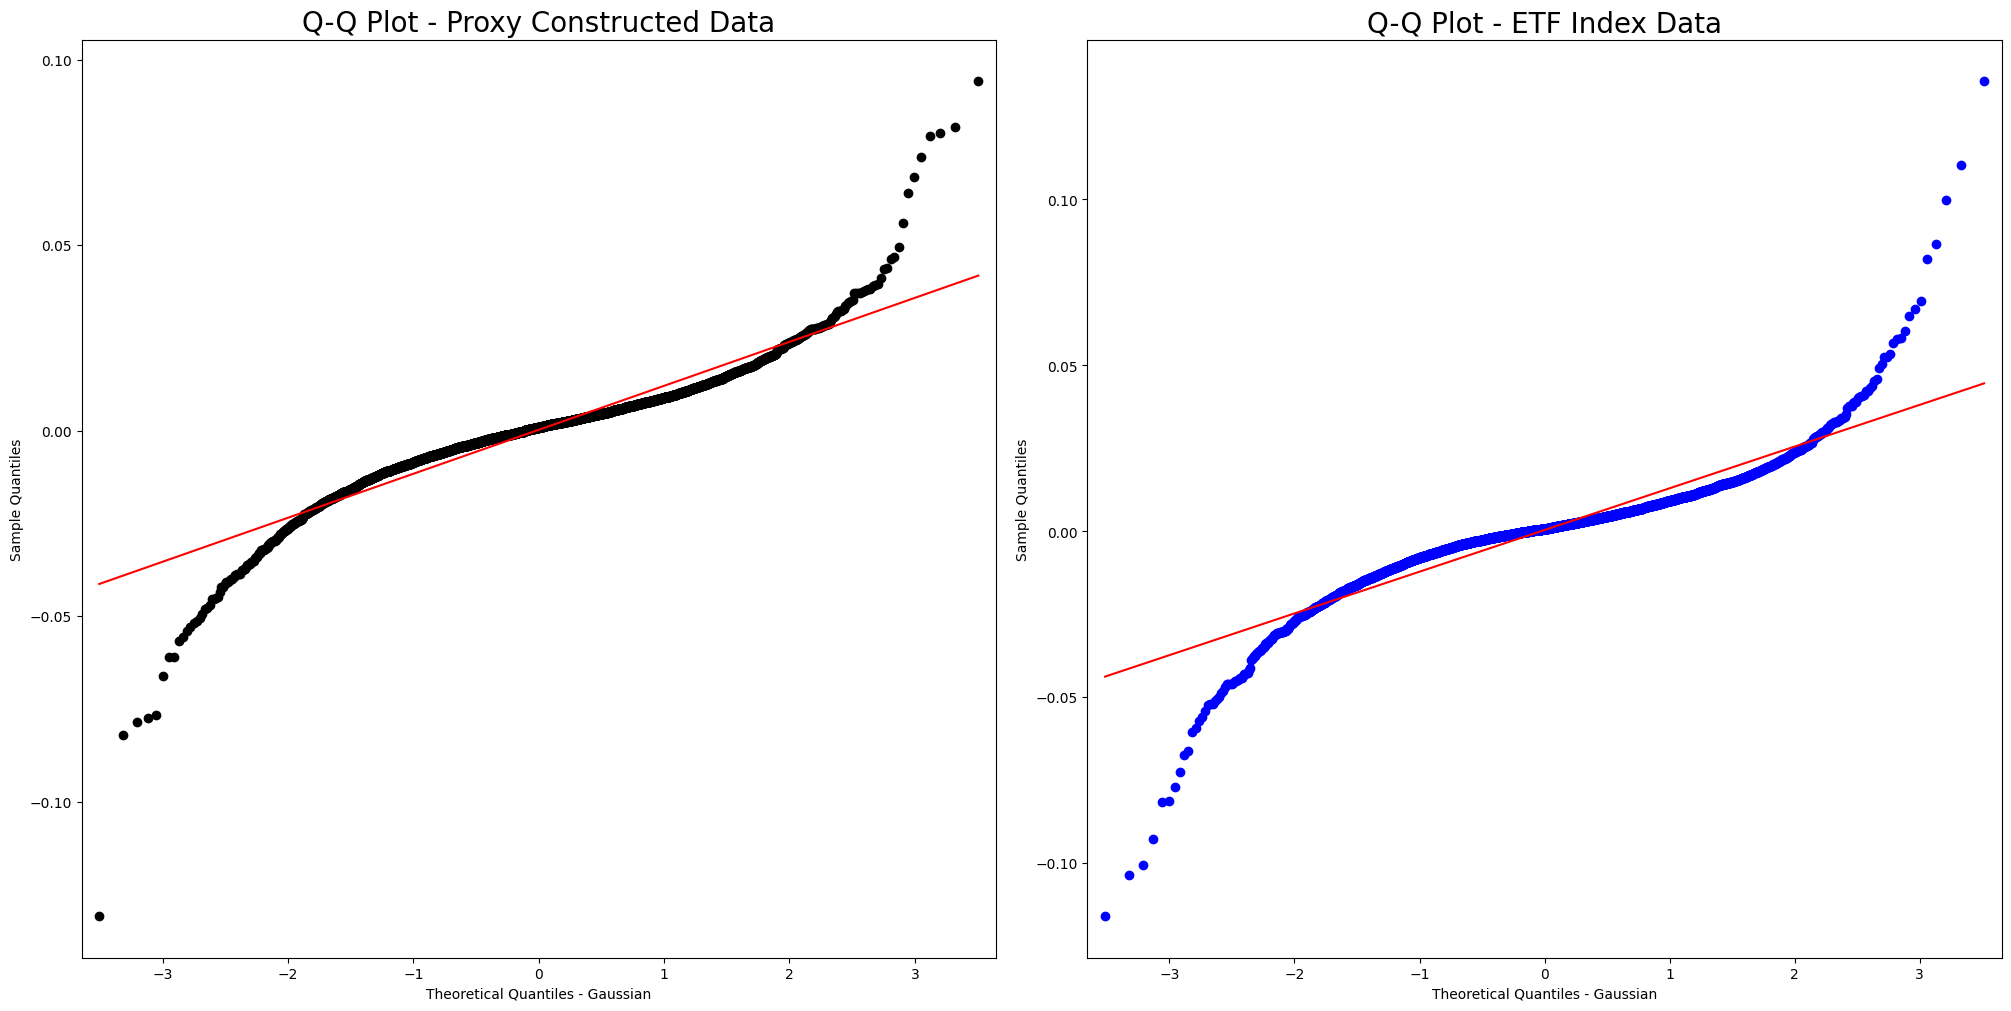

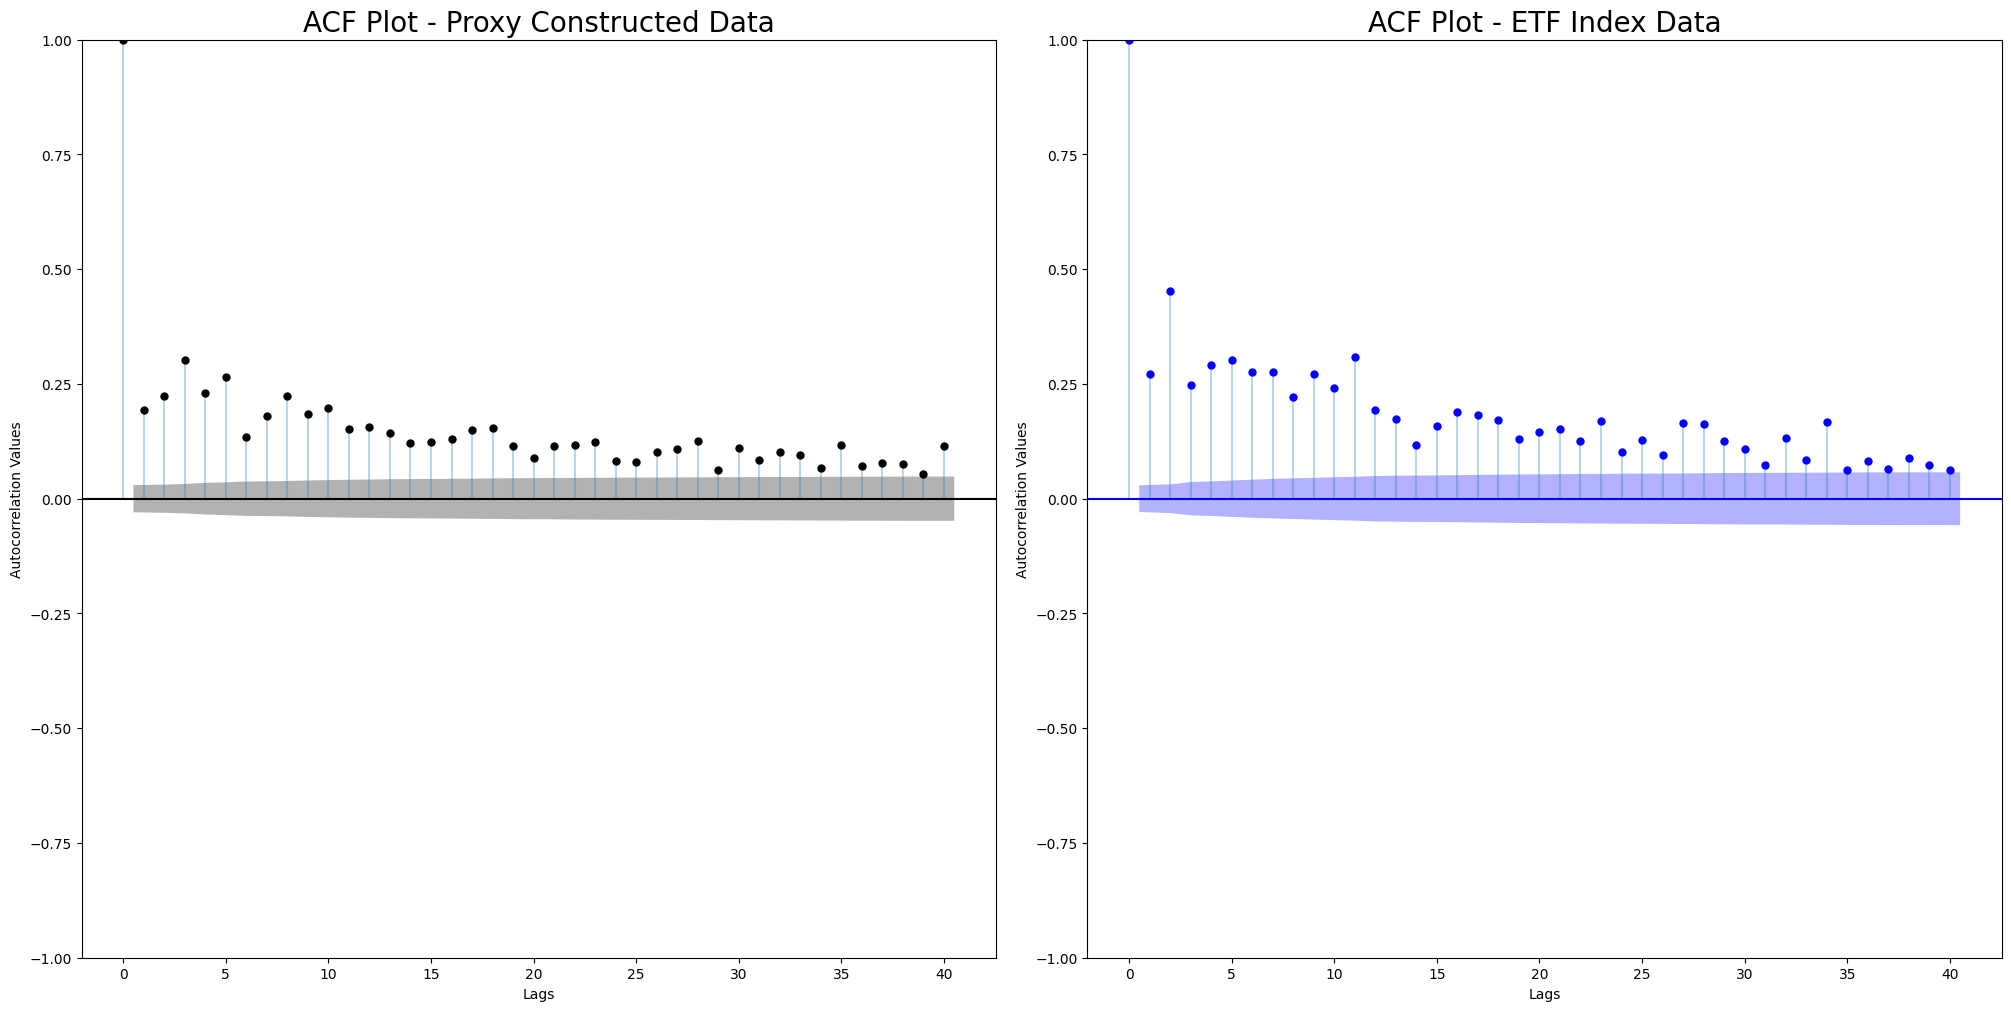

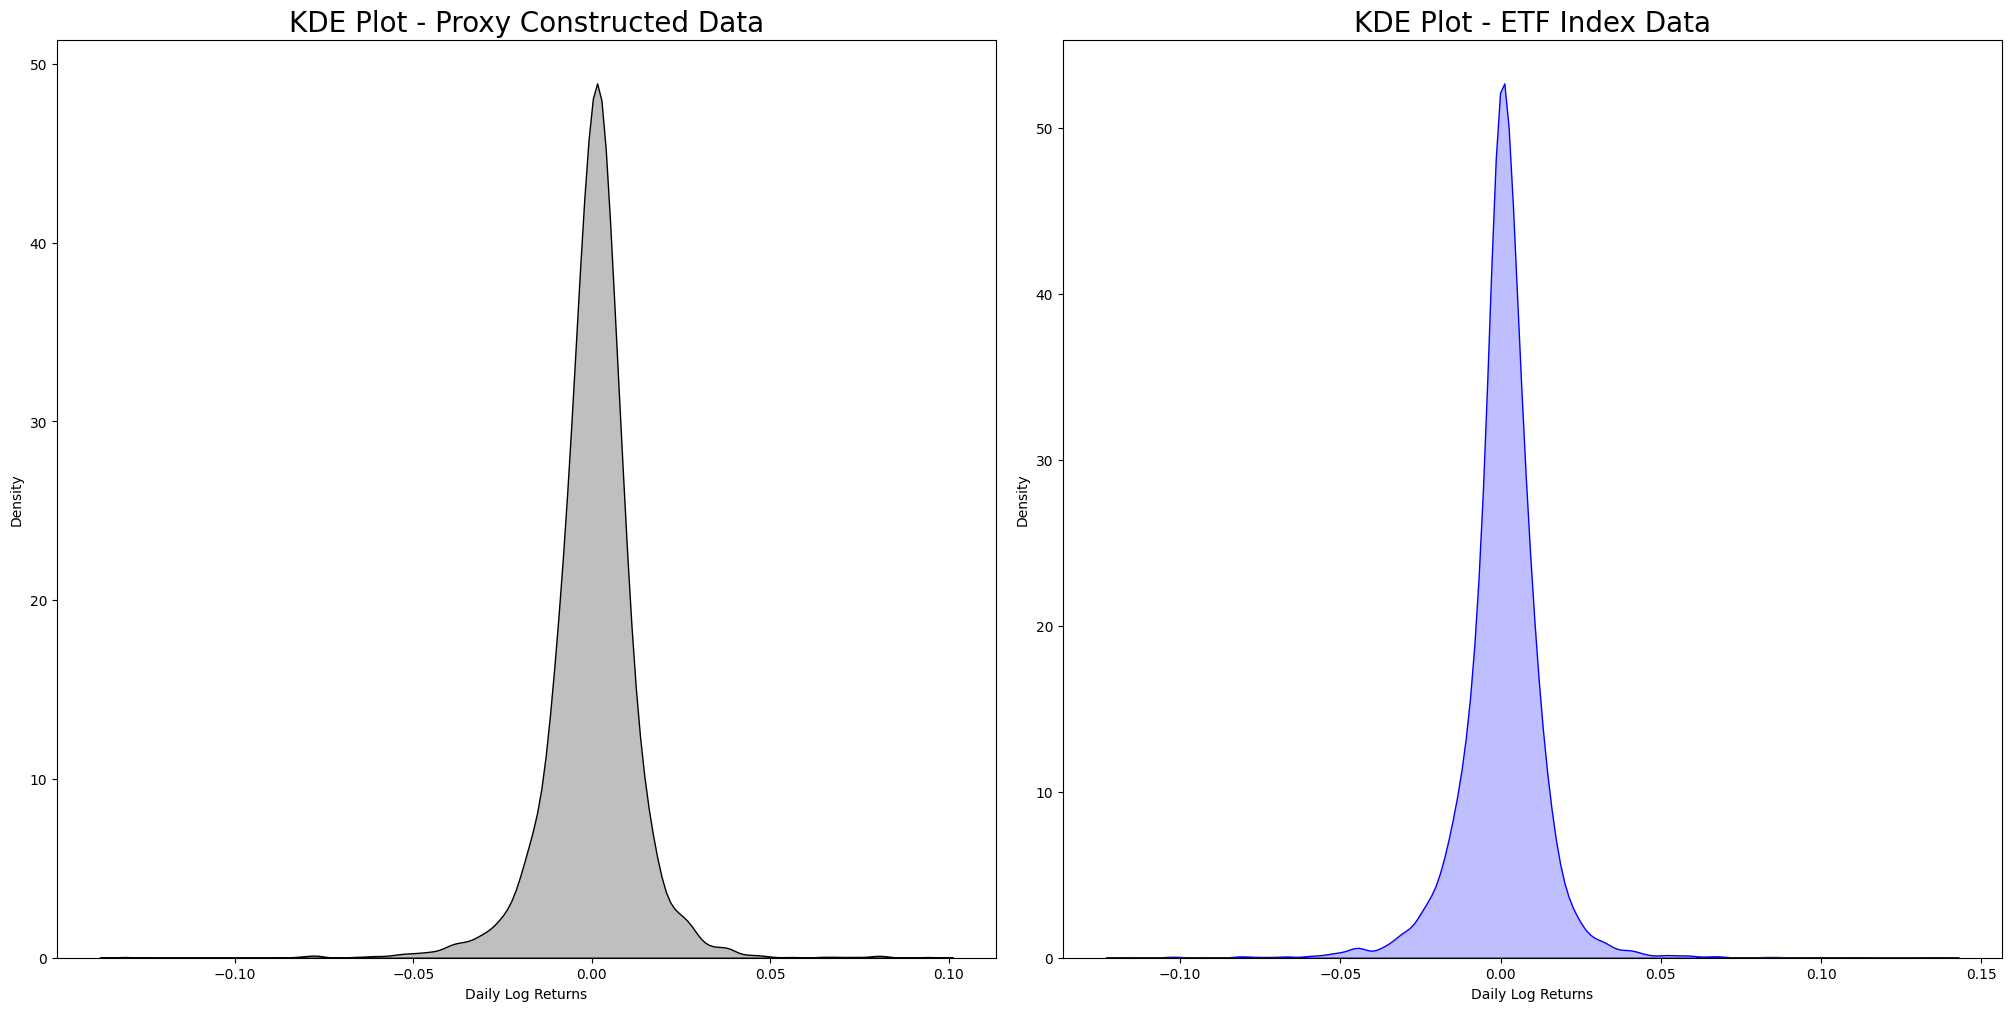

In [7]:
df_proxy_master = pd.read_pickle(proxy_master)
df_etf_master = yf.download(tickers='SPY', start='2008-01-01', end='2026-02-01', progress=False)
df_etf_master = (
    df_etf_master
    .xs('Close', level='Price', axis=1)
    .rename(columns={'SPY': 'index_closing_prices'})
    .sort_index()
)
df_etf_master['index_closing_simple_ret'] = df_etf_master['index_closing_prices'].pct_change()
df_etf_master['index_closing_log_ret'] = np.log(1 + df_etf_master['index_closing_simple_ret'])
df_etf_master = df_etf_master.dropna(how='any')

# Summary of proxy dataset
print('Summary of proxy data:')
display(df_proxy_master.describe())
prxy_log_returns = df_proxy_master['index_closing_log_ret'].drop_duplicates().to_numpy()
prxy_sq_log_returns = prxy_log_returns ** 2

# Summary of ETF dataset
print('Summary of ETF data:')
display(df_etf_master.describe())
etf_log_returns = df_etf_master['index_closing_log_ret'].drop_duplicates().to_numpy()
etf_sq_log_returns = etf_log_returns ** 2

# Generating Q-Q plots
fig_qq, ax_qq = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), dpi=100, constrained_layout=True)
sm.qqplot(
    prxy_log_returns,
    dist=stats.norm,
    line='s',
    markerfacecolor='black',
    markeredgecolor='black',
    ax=ax_qq[0]
)
sm.qqplot(
    etf_log_returns,
    dist=stats.norm,
    line='s',
    markerfacecolor='blue',
    markeredgecolor='blue',
    ax=ax_qq[1]
)
ax_qq[0].set_title('Q-Q Plot - Proxy Constructed Data', fontsize=20)
ax_qq[0].set_xlabel('Theoretical Quantiles - Gaussian', fontsize=10)
ax_qq[0].set_ylabel('Sample Quantiles', fontsize=10)
ax_qq[1].set_title('Q-Q Plot - ETF Index Data', fontsize=20)
ax_qq[1].set_xlabel('Theoretical Quantiles - Gaussian', fontsize=10)
ax_qq[1].set_ylabel('Sample Quantiles', fontsize=10)
plt.show()

# Generating ACF plots
fig_acf, ax_acf = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), constrained_layout=True)
plot_acf(
    prxy_sq_log_returns,
    lags=40,
    alpha=0.05, # significance level
    ax=ax_acf[0]
)
for lines in ax_acf[0].lines:
    lines.set_color('black')

for collections in ax_acf[0].collections:
    collections.set_facecolor('black')
    collections.set_alpha(0.3) # for opacity

plot_acf(
    etf_sq_log_returns,
    lags=40,
    alpha=0.05,
    ax=ax_acf[1]
)
for lines in ax_acf[1].lines:
    lines.set_color('blue')

for collections in ax_acf[1].collections:
    collections.set_facecolor('blue')
    collections.set_alpha(0.3) # for opacity

ax_acf[0].set_title('ACF Plot - Proxy Constructed Data', fontsize=20)
ax_acf[0].set_xlabel('Lags', fontsize=10)
ax_acf[0].set_ylabel('Autocorrelation Values', fontsize=10)
ax_acf[1].set_title('ACF Plot - ETF Index Data', fontsize=20)
ax_acf[1].set_xlabel('Lags', fontsize=10)
ax_acf[1].set_ylabel('Autocorrelation Values', fontsize=10)
plt.show()

# Generating KDE plots
fig_kde, ax_kde = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), dpi=100, constrained_layout=True)
sns.kdeplot(
    prxy_log_returns,
    bw_method='silverman',
    bw_adjust=1,
    color='black',
    fill=True,
    ax=ax_kde[0]
)
sns.kdeplot(
    etf_log_returns,
    bw_method='silverman',
    bw_adjust=1,
    color='blue',
    fill=True,
    ax=ax_kde[1]
)
ax_kde[0].set_title('KDE Plot - Proxy Constructed Data', fontsize=20)
ax_kde[0].set_xlabel('Daily Log Returns', fontsize=10)
ax_kde[0].set_ylabel('Density', fontsize=10)
ax_kde[1].set_title('KDE Plot - ETF Index Data', fontsize=20)
ax_kde[1].set_xlabel('Daily Log Returns', fontsize=10)
ax_kde[1].set_ylabel('Density', fontsize=10)
plt.show()

**Findings from ACF, KDE and Q-Q plots**

 - **Tail Symmetry (Skewness):** The presence of an almost equivalent cluster of points on the top and bottom of the fitted line (constructed using sample mean and variance) suggests a symmetric behavior of both proxy and ETF datasets. This is further supported by visually inspecting the KDE plots as well.

 - **Tail Thickness (Kurtosis):** The presence of a high cluster of points on the top and bottom of the fitted line (constructed using sample mean and variance) suggests a leptokurtic behavior (as demonstrated by the pronounced S-shape of both graphs) in the tails of both datasets. This is further supported by visually inspecting the KDE plots as well.

 - **Deviations from Gaussian Benchmark:** Visual inspection of the Q-Q plots (of both proxy and ETF datasets) suggests extreme deviations in terminal quantiles consistent with the presence of large-magnitude risk and return realizations - relative to the Gaussian benchmark. Given the findings from kurtosis inspection, this finding is not an antithesis.

 - **Volatility Clustering (Heteroskedasticity):** Visual inspection of the ACF plot (on squared log returns) suggests the presence of volatility clusters - based on sustained persistence in the data (past patterns repeating) in both datasets. Additionally, multiple lags exhibit statistically significant positive autocorrelation - beyond the 95% confidence band - indicating persistent variance.

In conclusion, these visual diagnostics strongly indicate non-Gaussian distributional characteristics and persistent conditional heteroskedasticity - which will be formally evaluated through identified statistical tests implemented in the next sub-section.

### Section 3.2: Statistical Tests on Proxy and ETF Data

As outlined in the beginning of this section, the following statistical tests will be applied on the proxy and ETF datasets:

 1. Tests for kurtosis and skewness - applied on both proxy and ETF data
 2. Tests for normality rejection (AD and JB) - applied on both proxy and ETF data
 3. Tests for volatility clustering (LB and Engle's ARCH) - applied only on proxy data

This sub-section focuses on applying each test and documenting individual (as well as collective) findings from the same.

In [9]:
# Test for kurtosis - proxy and ETF data
print('============Performing test for kurtosis============')
kurt_out_normal_prxy = 'Outcome: Normal tail behavior in proxy dataset.'
kurt_out_lepto_prxy = 'Outcome: Leptokurtic tails in proxy dataset.'
kurt_out_platy_prxy = 'Outcome: Platykurtic tails in proxy dataset.'
kurt_out_normal_etf = 'Outcome: Normal tail behavior in etf dataset.'
kurt_out_lepto_etf = 'Outcome: Leptokurtic tails in etf dataset.'
kurt_out_platy_etf = 'Outcome: Platykurtic tails in etf dataset.'
kurt_prxy = kurtosis(
    prxy_log_returns,
    fisher=True, # capturing excess kurtosis
    bias=False # applying bias correction
)
kurt_etf = kurtosis(
    etf_log_returns,
    fisher=True,
    bias=False
)
if kurt_prxy == 0:
    print(f'Kurtosis: {kurt_prxy:.4f}. {kurt_out_normal_prxy}')
elif kurt_prxy > 0:
    print(f'Kurtosis: {kurt_prxy:.4f}. {kurt_out_lepto_prxy}')
else:
    print(f'Kurtosis: {kurt_prxy:.4f}. {kurt_out_platy_prxy}')
if kurt_etf == 0:
    print(f'Kurtosis: {kurt_etf:.4f}. {kurt_out_normal_etf}')
elif kurt_etf > 0:
    print(f'Kurtosis: {kurt_etf:.4f}. {kurt_out_lepto_etf}')
else:
    print(f'Kurtosis: {kurt_etf:.4f}. {kurt_out_platy_etf}')

# Test for skewness - proxy and ETF data
print('\n============Performing test for skewness============')
skew_out_normal_prxy = 'Outcome: Proxy data distribution is symmetric.'
skew_out_right_prxy = 'Outcome: Proxy data distribution is right-skewed.'
skew_out_left_prxy = 'Outcome: Proxy data distribution is left-skewed.'
skew_out_normal_etf = 'Outcome: ETF data distribution is symmetric.'
skew_out_right_etf = 'Outcome: ETF data distribution is right-skewed.'
skew_out_left_etf = 'Outcome: ETF data distribution is left-skewed.'
skew_prxy = skew(
    prxy_log_returns,
    bias=False
)
skew_etf = skew(
    etf_log_returns,
    bias=False
)
if skew_prxy == 0:
    print(f'Skewness: {skew_prxy:.4f}. {skew_out_normal_prxy}')
elif skew_prxy > 0:
    print(f'Skewness: {skew_prxy:.4f}. {skew_out_right_prxy}')
else:
    print(f'Skewness: {skew_prxy:.4f}. {skew_out_left_prxy}')
if skew_etf == 0:
    print(f'Skewness: {skew_etf:.4f}. {skew_out_normal_etf}')
elif skew_etf > 0:
    print(f'Skewness: {skew_etf:.4f}. {skew_out_right_etf}')
else:
    print(f'Skewness: {skew_etf:.4f}. {skew_out_left_etf}')

# Tests for normality rejection - Anderson-Darling (AD) - proxy and ETF data
print('\n============Performing AD test for normality rejection: H0 - Returns are normally distributed============')
ad_out_reject_prxy = 'Outcome: Reject H0 - Proxy data log returns do not follow normal distribution.'
ad_out_reject_etf = 'Outcome: Reject H0 - ETF data log returns do not follow normal distribution.'
ad_out_fail_prxy = 'Outcome: Fail to Reject H0 - Proxy data log returns follow normal distribution.'
ad_out_fail_etf = 'Outcome: Fail to Reject H0 - ETF data log returns follow normal distribution.'
ad_prxy = anderson(
    prxy_log_returns,
    dist='norm'
)
ad_etf = anderson(
    etf_log_returns,
    dist='norm'
)
print(f'Proxy data AD test results:\nTest Statistic: {ad_prxy.statistic:.4f}\nCritical Value @5% Significance: {ad_prxy.critical_values[2]:.4f}')
if ad_prxy.statistic > ad_prxy.critical_values[2]:
    print(ad_out_reject_prxy)
else:
    print(ad_out_fail_prxy)
print(f'ETF data AD test results:\nTest Statistic: {ad_etf.statistic:.4f}\nCritical Value @5% Significance: {ad_etf.critical_values[2]:.4f}')
if ad_etf.statistic > ad_etf.critical_values[2]:
    print(ad_out_reject_etf)
else:
    print(ad_out_fail_etf)

# Tests for normality rejection - Jarque-Bera (JB) - proxy and ETF data
print('\n============Performing JB test for normality rejection: H0 - Returns are normally distributed============')
alpha = 0.05
jb_out_reject_prxy = 'Outcome: Reject H0 - Proxy data log returns do not follow normal distribution.'
jb_out_reject_etf = 'Outcome: Reject H0 - ETF data log returns do not follow normal distribution.'
jb_out_fail_prxy = 'Outcome: Fail to Reject H0 - Proxy data log returns follow normal distribution.'
jb_out_fail_etf = 'Outcome: Fail to Reject H0 - ETF data log returns follow normal distribution.'
jb_prxy_stat, jb_prxy_p = jarque_bera(prxy_log_returns)
jb_etf_stat, jb_etf_p = jarque_bera(etf_log_returns)
print(f'Proxy data JB test results:\nTest Statistic: {jb_prxy_stat:.4f}\nP-Value: {jb_prxy_p:.4f}')
if jb_prxy_p < alpha:
    print(jb_out_reject_prxy)
else:
    print(jb_out_fail_prxy)
print(f'ETF data JB test results:\nTest Statistic: {jb_etf_stat:.4f}\nP-Value: {jb_etf_p:.4f}')
if jb_etf_p < alpha:
    print(jb_out_reject_etf)
else:
    print(jb_out_fail_etf)

# Tests for volatility clustering - Ljung-Box (LB) - proxy only
print('\n============Performing LB test for volatility clustering: H0 - No autocorrelation in squared returns upto Lag(h)============')
lb_outcomes = []
lb_out_reject = 'Reject H0 - Proxy data squared log returns dmeonstrate auto-correlation and by extension - volatility clustering.'
lb_out_fail = 'Fail to Reject H0 - Proxy data squared log returns dmeonstrate no auto-correlation and by extension - no volatility clustering.'
lb_prxy = acorr_ljungbox(
    prxy_sq_log_returns,
    lags=[10, 20, 40],
    return_df=True
)
print('Proxy data LB test results:')
if lb_prxy['lb_pvalue'].iloc[0] < alpha:
    lb_outcomes.append(lb_out_reject)
else:
    lb_outcomes.append(lb_out_fail)
if lb_prxy['lb_pvalue'].iloc[1] < alpha:
    lb_outcomes.append(lb_out_reject)
else:
    lb_outcomes.append(lb_out_fail)
if lb_prxy['lb_pvalue'].iloc[2] < alpha:
    lb_outcomes.append(lb_out_reject)
else:
    lb_outcomes.append(lb_out_fail)

lb_prxy['Outcomes'] = lb_outcomes
lb_prxy.index.name = 'Lags'
lb_prxy_sty = (
    lb_prxy.style
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "left")]}  # left is better for long text
    ])
    .set_properties(**{
        "white-space": "pre-wrap",
        "word-wrap": "break-word",
        "overflow-wrap": "break-word",
        "max-width": "600px"      # adjust as needed
    })
    .set_table_attributes('style="table-layout:fixed;width:100%"')
)
display(lb_prxy_sty)

# Tests for volatility clustering - Auto Regressive Conditional Heteroskedasticity (Engle's ARCH) - proxy only
print('\n============Performing ARCH test for volatility clustering: H0 - No ARCH effects============')
lm_prxy_stat, lm_prxy_pvalue, f_prxy_stat, f_prxy_pvalue = het_arch(prxy_sq_log_returns, nlags=10)
lm_out_reject = 'Reject H0 - ARCH structure exists in proxy data.'
lm_out_fail = 'Fail to Reject H0 - No ARCH structure exists in proxy data.'
print(f'Proxy data ARCH test results:')
idx = [0]
arch_prxy_df = pd.DataFrame(
    {
        'Lagrange Multiplier Statistic': lm_prxy_stat,
        'Finite Sample Statistic': f_prxy_stat,
        'Lagrange Multiplier P-Value': lm_prxy_pvalue,
        'Finite Sample P-Value': f_prxy_pvalue
    },
    index=idx
)
display(arch_prxy_df)
if lm_prxy_pvalue < alpha:
    print(lm_out_reject)
else:
    print(lm_out_fail)

# Consolidated output of all statistical tests
print('\n============Consolidated Results of All Statistical Tests============')
data = {
    'Test Name': [
        'Test for kurtosis (Excess Value)',
        'Test for skewness (Value)',
        'AD test for normality rejection (Statistic, Critical Value)',
        'JB test for normality rejection (P-Value)',
        'LB test for volatility clustering (P-Value at Lag = 40)',
        'ARCH test for volatility clustering (Lagrange Multiplier P-Value)'
    ],
    'Proxy Data Standard Log Returns - Test Results': [
        kurt_prxy,
        skew_prxy,
        (ad_prxy.statistic, ad_prxy.critical_values[2]),
        jb_prxy_p,
        'NaN',
        'NaN'
    ],
    'ETF Data Standard Log Returns - Test Results': [
        kurt_etf,
        skew_etf,
        (ad_etf.statistic, ad_etf.critical_values[2]),
        jb_etf_p,
        'NaN',
        'NaN'
    ],
    'Proxy Data Squared Log Returns - Test Results': [
        'NaN',
        'NaN',
        'NaN',
        'NaN',
        lb_prxy['lb_pvalue'].iloc[2],
        lm_prxy_pvalue
    ],
    'ETF Data Squared Log Returns - Test Results': [
        'NaN',
        'NaN',
        'NaN',
        'NaN',
        'Test not performed',
        'Test not performed'
    ],
    'Proxy Data Outcomes': [
        kurt_out_lepto_prxy,
        skew_out_left_prxy,
        ad_out_reject_prxy,
        jb_out_reject_prxy,
        lb_prxy['Outcomes'].iloc[2],
        lm_out_reject
    ],
    'ETF Data Outcomes': [
        kurt_out_lepto_etf,
        skew_out_left_etf,
        ad_out_reject_etf,
        jb_out_reject_etf,
        'Test not performed',
        'Test not performed'
    ]
}
stats_master_df = pd.DataFrame(data)
stats_master_df.index.name = 'SNo.'
stats_master_df_sty = (
    stats_master_df.style
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "left")]}  # left is better for long text
    ])
    .set_properties(**{
        "white-space": "pre-wrap",
        "word-wrap": "break-word",
        "overflow-wrap": "break-word",
        "max-width": "600px"      # adjust as needed
    })
    .set_table_attributes('style="table-layout:fixed;width:100%"')
)
display(stats_master_df_sty)

============Performing test for kurtosis============
Kurtosis: 10.2664. Outcome: Leptokurtic tails in proxy dataset.
Kurtosis: 14.0565. Outcome: Leptokurtic tails in etf dataset.

============Performing test for skewness============
Skewness: -0.5576. Outcome: Proxy data distribution is left-skewed.
Skewness: -0.2954. Outcome: ETF data distribution is left-skewed.

============Performing AD test for normality rejection: H0 - Returns are normally distributed============
Proxy data AD test results:
Test Statistic: 74.8272
Critical Value @5% Significance: 0.7860
Outcome: Reject H0 - Proxy data log returns do not follow normal distribution.
ETF data AD test results:
Test Statistic: 116.3344
Critical Value @5% Significance: 0.7860
Outcome: Reject H0 - ETF data log returns do not follow normal distribution.

============Performing JB test for normality rejection: H0 - Returns are normally distributed============
Proxy data JB test results:
Test Statistic: 19453.0269
P-Value: 0.0000
Outcome: 

,lb_stat,lb_pvalue,Outcomes
Lags,,,
10,2087.469984,0.000000,Reject H0 - Proxy data squared log returns dmeonstrate auto-correlation and by extension - volatility clustering.
20,2889.843748,0.000000,Reject H0 - Proxy data squared log returns dmeonstrate auto-correlation and by extension - volatility clustering.
40,3717.851516,0.000000,Reject H0 - Proxy data squared log returns dmeonstrate auto-correlation and by extension - volatility clustering.



============Performing ARCH test for volatility clustering: H0 - No ARCH effects============
Proxy data ARCH test results:


,Lagrange Multiplier Statistic,Finite Sample Statistic,Lagrange Multiplier P-Value,Finite Sample P-Value
0,178.4786,18.5595,0.0000,0.0000


Reject H0 - ARCH structure exists in proxy data.

============Consolidated Results of All Statistical Tests============


,Test Name,Proxy Data Standard Log Returns - Test Results,ETF Data Standard Log Returns - Test Results,Proxy Data Squared Log Returns - Test Results,ETF Data Squared Log Returns - Test Results,Proxy Data Outcomes,ETF Data Outcomes
SNo.,,,,,,,
0,Test for kurtosis (Excess Value),10.266366,14.056484,NaN,NaN,Outcome: Leptokurtic tails in proxy dataset.,Outcome: Leptokurtic tails in etf dataset.
1,Test for skewness (Value),-0.557648,-0.295439,NaN,NaN,Outcome: Proxy data distribution is left-skewed.,Outcome: ETF data distribution is left-skewed.
2,"AD test for normality rejection (Statistic, Critical Value)","(74.82724825421337, 0.786)","(116.3344107499488, 0.786)",NaN,NaN,Outcome: Reject H0 - Proxy data log returns do not follow normal distribution.,Outcome: Reject H0 - ETF data log returns do not follow normal distribution.
3,JB test for normality rejection (P-Value),0.000000,0.000000,NaN,NaN,Outcome: Reject H0 - Proxy data log returns do not follow normal distribution.,Outcome: Reject H0 - ETF data log returns do not follow normal distribution.
4,LB test for volatility clustering (P-Value at Lag = 40),NaN,NaN,0.000000,Test not performed,Reject H0 - Proxy data squared log returns dmeonstrate auto-correlation and by extension - volatility clustering.,Test not performed
5,ARCH test for volatility clustering (Lagrange Multiplier P-Value),NaN,NaN,0.000000,Test not performed,Reject H0 - ARCH structure exists in proxy data.,Test not performed


**Findings from Statistical Tests**

 - **Tail Symmetry (Skewness):** While the KDE and Q-Q plots did not present clear evidence of a skew in either datasets, test for skewness provides empirical evidence that both datasets are marginally left-skewed with ETF data (skewness = -0.29) demonstrating a milder negative skew compared to the proxy data (skewness = -0.56).

 - **Tail Thickness (Kurtosis):** Test for kurtosis (Fisher's - Excess Kurtosis) confirms what the KDE and Q-Q plots visually demonstrated in the previous section. I.e., both proxy and ETF datasets demonstrate significant leptokurtosis in their tails with ETF data (excess kurtosis = 14.06) demonstrating fatter tails compared to the proxy dataset (excess kurtosis = 10.26).

**Findings from both skewness and kurtosis tests support general understanding of the log distributions of financial returns - left-skewed with leptokurtic tails - in equities.**

 - **Deviations from Gaussian Benchmark:** Both Anderson-Darling and Jarque-Bera tests strongly reject normality in both proxy and ETF datasets - providing clear evidence that underlying log returns (under historical P-measures - our datasets) deviate materially from Gaussian assumptions.

 - **Volatility Clustering (Heteroskedasticity):** While Ljung-Box test confirms the presence of volatility clustering, Engle's Auto Regressive Conditional Heteroskedasticity confirms that an ARCH structure exists in the proxy data. Both these tests collectively reject the hypothesis that underlying log returns are i.i.d.

**Conclusion of statistical tests on historical P-measures:**
**Our statistical tests provide us with empirical evidence on two key assumptions on the underlying log returns (historical P-measures):**
 **1. Normality - Log returns are not normal**
 **2. I.I.D - Log returns are not i.i.d**

>**Implication of findings:**
>What the conclusion of our statistical tests tell us - in the broader context of this project - is that while Black-Scholes Merton and Gaussian MC (both using Geometric Brownian Motion under the hood - which relies on constant volatility, i.i.d and risk-neutral assumptions) are an analytically convinient baseline - and are widely adopted for option pricing - for risk sensitive applications (such as this project - downstream risk measurement of option prices) both are structurally limited since presence of volatility and variance clusters in "P" suggests that volatility persistence is unlikely to disappear under the risk-neutral measure "Q" as volatility dynamics often persist across measures. Hence, Heston and Non-Parametric (Block Bootstrap) Monte-Carlo seem to be more suited in the context of this project as they are better suited to capture variance persistence and distributional asymmetry in simulated price dynamics.

## Section 4: Implementation of Black-Scholes Merton, Heston and Non-Parametric (Block Bootstrap) Monte-Carlo

In line with our project implementation methodology (outlined in the introduction and summary section of this notebook), this section focuses on the initial model development for the three models being considered:

 1. Black-Scholes Merton
 2. Heston
 3. Non-Parametric (Block Bootstrap) Monte-Carlo

Hence, this section is further sub-divided into three sub-sections - each dedicated to implementing the three models above respectively. Each sub-section starts with a brief overview and mechanics of its model and then proceeds to incorporate the implementation code-base.

This section will conclude with the explanation and implementation codes for each model. The implementation codebase will be further called in downstream sections of model bechmarking, OOS evaluation and final conclusions.

### Section 4.1: Overview and implementation of Black-Scholes Merton (BSM)

This sub-section is dedicated towards providing an overview and mechanics of the BSM model as well as an implementation codebase for the same. Prior to diving into the model itself, it is crucial for us to understand the main engine behind the model - Geometric Brownian Motion.

**Geometric Brownian Motion (GBM):**

The GBM model serves as the foundational framework for BSM. At its core, it is a stochastic model that makes concrete assumptions:

 1. Log returns are normally distributed - meaning that log-returns follow a Gaussian distribution (normal tails and normal skew).
 $$
 \ln\left(\frac{S_t}{S_0}\right) \sim \mathcal{N}\left(\left(\mu - \frac{1}{2}\sigma^2\right)t,\; \sigma^2 t\right)
 $$

 2. Constant instantaneous volatility - meaning that there are no volatility/ variance clusters, no stochastic volatility and no regime switching demonstrated by the log returns.
 $$
 \sigma = constant
 $$

 3. Increments being i.i.d - meaning that log-return increments over non-overlapping intervals are independent and identically distributed (with variance proportional to interval length).
 $$
 W_{t+s} - W_t \sim \mathcal{N}\left(0,\; s\right), \quad s > 0
 $$

 4. Underlying data following continuous paths (no jumps) - meaning that price changes occur in infinitesimally small increments driven solely by Brownian motion (Wiener process $W_t$). There are no discontinuities, gaps, or sudden jump events in the price process.
 $$
 \lim_{\Delta t \to 0} S_{t+\Delta t} = S_t
 $$

In contrast, and as evidenced from our statistical tests above, real markets often exhibit:
 1. Left-skewed and leptokurtic log returns
 2. Strong presence of volatility clusters
 3. Conditional heteroskedasticity
 4. Jump clustering and macro-shock discontinuities

>**Note:**
>Since the above real world scenarios cannot be captured by GBM and require jump-diffusion/ stochastic-diffusion models (like Merton Jump Diffusion/ Heston) it renders the overarching BSM incapable of capturing volatility smile, clustering and structurally misspecified for higher moments.

The GBM model comes in two forms - risk neutral (Q) measure and historical (P) measure. The only point of difference between the two is that while the risk neutral measure (Q) uses risk-free rate for drift calculation, the historical (P) measure uses expected return - derived from our underlying real world data. Below is an outline of the mechanics involved in each.

*Risk Neutral Geometric Brownian Motion:*

Below is the core SDE of the risk neutral GBM model. While in implementation (and practice) its Log-Returns form (incorporating Ito's Lemma) is used, the SDE form encapsulates the model's core definition and assumptions.

$$
dS_t = (r - q) S_t \, dt + \sigma S_t \, dW_t^{\mathbb{Q}}
$$
Where:
 - $S_t$: Underlying asset price
 - $r$: Risk free rate
 - $q$: Continuous dividend yeild
 - $r - q$: Drift term
 - $\sigma$: Constant volatility
 - $W_t^{\mathbb{Q}}$: Standard Brownian motion under the risk neutral measure $\mathbb{Q}$ (Wiener Process)

*Historical P-measure Geometric Brownian Motion:*

As explained above, the only differentiating factor between the risk-neutral GBM and historical P-measure GBM is in the mechanics of drift calculation. All other structural assumptions that make up the core of GBM stay as-is. Hence, under historical P-measure, the SDE changes to:

$$
dS_t = (\mu - q) S_t \, dt + \sigma S_t \, dW_t^{\mathbb{P}}
$$
Where:
 - $S_t$: Underlying asset price
 - $\mu$: Expected return
 - $q$: Continuous dividend yeild
 - $\mu - q$: Drift term
 - $\sigma$: Constant volatility
 - $W_t^{\mathbb{P}}$: Standard Brownian motion under the historical P-measure $\mathbb{P}$ (Wiener Process)

For this implementation, we will leverage the log-returns form of the risk-neutral GBM model defined using:

$$
d \ln S_t = \left( r - q - \frac{1}{2}\sigma^2 \right) dt + \sigma \, dW_t^{\mathbb{Q}}
$$

**Black–Scholes–Merton (BSM) Model under the Risk-Neutral Measure**

For this project, we will be implementing the BSM model under risk neutral measure. Under the risk-neutral probability measure $\mathbb{Q}$, the underlying asset price $S_t$ follows a Geometric Brownian Motion with drift equal to the risk-free rate adjusted for continuous dividends:

$$
dS_t = (r - q) S_t \, dt + \sigma S_t \, dW_t^{\mathbb{Q}}
$$

Where:
- $S_t$: underlying asset price  
- $r$: continuously compounded risk-free rate  
- $q$: continuous dividend yield  
- $\sigma$ = constant volatility  
- $W_t^{\mathbb{Q}}$ = standard Brownian motion under the risk-neutral measure  

Under $\mathbb{Q}$ and $\sigma = 0$, the SDE becomes deterministic and discounted asset price process satisfies the martingale condition:

$$
\mathbb{E}^{\mathbb{Q}} \left[ e^{-rT} S_T \mid \mathcal{F}_t \right] = e^{-rt} S_t
$$

Where:
 - $\mathcal{F}_t$: All market information observed up to time $t$

Solving the SDE yields the closed-form expression:

$$
S_T = S_0 e^{\left( \left( r - q - \frac{1}{2}\sigma^2 \right)T + \sigma W_T^{\mathbb{Q}} \right)}
$$

which implies that $S_T$ is log-normally distributed under the risk-neutral measure.

**Closed-Form Option Pricing Formula**

For a European call option with strike $K$ and maturity $T$, the Black–Scholes–Merton price is:

$$
C(S_0, K, T) = S_0 e^{-qT} \Phi(d_1) - K e^{-rT} \Phi(d_2)
$$

For a European put option:

$$
P(S_0, K, T) = K e^{-rT} \Phi(-d_2) - S_0 e^{-qT} \Phi(-d_1)
$$

Where:
$$
d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r - q + \frac{1}{2}\sigma^2\right)T}{\sigma \sqrt{T}}
$$

$$
d_2 = d_1 - \sigma \sqrt{T}
$$

and $\Phi(\cdot)$ denotes the cumulative distribution function of the standard normal distribution.

$$
\Phi(x) = \frac{1}{2} \left( 1 + \operatorname{erf}\left( \frac{x}{\sqrt{2}} \right) \right)
$$

**Key Structural Implications**

- Pricing is performed under the risk-neutral measure $\mathbb{Q}$  
- Volatility $\sigma$ is constant across strike and maturity  
- The model produces a flat implied volatility surface  
- Higher-moment effects (skewness, kurtosis, clustering) are not captured  